# Trajectory
Our agent needs some path to move along for the environment-related challenges: we assume the agent having the intent to study the environment, so the path it follows is not random, the agent scans environment in a systematic way exploring full extend of available range of moveability.

In [1]:
import gym
import numpy as np
import numpy.random as rnd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
from gym_unity.envs import UnityEnv
%matplotlib inline

In [2]:
env_name = None # use Unity editor with SimpleEnvironment scene active
#env_name = './Exec/Background' # use executable
env = UnityEnv(env_name, worker_id = 0, use_visual = True)

INFO:mlagents.envs:Start training by pressing the Play button in the Unity Editor.
INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: SimpleEnvironment
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): [2]
        Vector Action descriptions: Turn HORIZONTAL, Tilt VERTICAL
INFO:gym_unity:1 agents within environment.


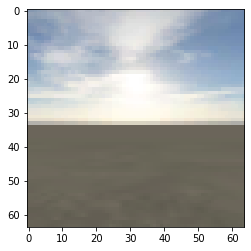

In [3]:
env.reset()
# get observation after taking action 0,0 (doing nothing)
observation, r, s, info = env.step([0.0, 0.0])

plt.imshow(observation)
plt.show()

In [4]:
IMG_DIM = observation.shape
ACT_DIM = (2,) # azimuth, altitude
N_CHANNELS = observation.shape[-1]
print('Image shape: {}  Flat size: {}  Channels: {}'\
      .format(IMG_DIM, np.prod(IMG_DIM), N_CHANNELS))

Image shape: (64, 64, 3)  Flat size: 12288  Channels: 3


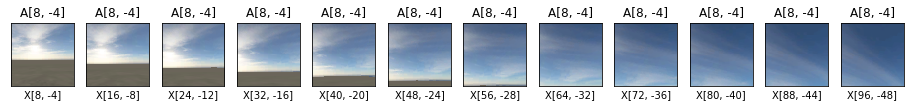

In [5]:
# collect observations executing squense of actions
def run_seq(actions, start = np.zeros((2,))):
    x = start
    observations, coords = [],[]
    for action in actions:
        view, _,__,___ = env.step(action)
        observations.append(view)
        x += action
        coords.append(tuple(x))
    return observations, coords

# show observed sequence
def show_seq(actions, observations, coords):
    n = len(observations)
    fig, ax = plt.subplots(1, n, figsize = (16,3))
    for i in range(n):    
        ax[i].imshow(observations[i])
        ax[i].set_title('A[%.0f, %.0f]' % tuple(actions[i]))
        ax[i].set_xlabel('X[%.0f, %.0f]' % tuple(coords[i]))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()

env.reset()
# A[ction]: turn 8 degrees right and 4 degrees up; perform 12 times
actions = [np.array([8., -4.]) for i in range(12)]
observations, coords = run_seq(actions)
show_seq(actions, observations, coords)

We can use a $sin$ curve to design a smooth cyclic path for our agent to travel along and cover a variety of (azimuth, altitude) combinations on the way. We are going to use it for the agent's online learning. We want more representation for `horizon` and `sky` and less for `ground` which is the most boring (less variable) in this case.

In [6]:
# get a continuous range of coords covered in defined #steps
def smooth_trajectory(steps):
    def trajectory(x):
        x += 45 # move down to set `cumulative zero` at zero
        return np.pi * np.sin(2 * x * np.pi / steps)
    return trajectory

In [7]:
AMPL = np.array([5., 1.])
STEPS = np.array([179., 83.])
START = np.array([0., 37.])

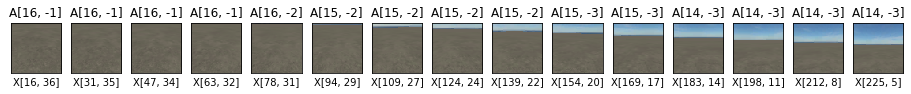

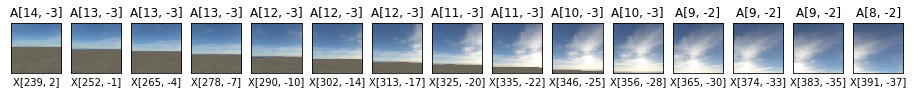

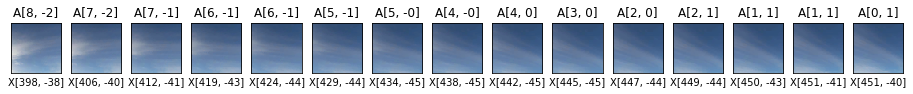

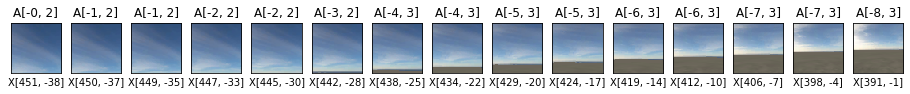

In [8]:
# visual check
r, c = 4, 15
path = smooth_trajectory(STEPS)
env.reset()
_,__,__,___ = env.step(START)
x = np.array(START)
start = START.copy()
# run sequence of r x c moves
for i in range(r):
    actions = [path(c * i + j) * AMPL for j in range(c)]
    observations, coords = run_seq(actions, start = start)
    start = tuple(coords[-1])
    show_seq(actions, observations, coords)

In [9]:
def init_trajectory(env, start = START, steps = STEPS):
    env.reset()
    _,__,__,___ = env.step(start)
    return smooth_trajectory(steps)

def make_move(env, trajectory, index, ampl = AMPL):
    action = ampl * trajectory(index)
    observation, _,__,___ = env.step(action)
    return observation, action

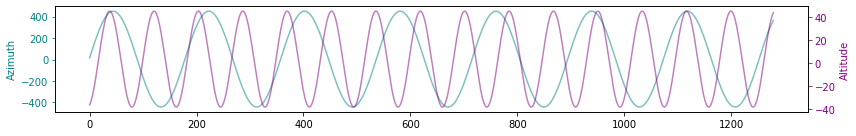

Azimuth range: -444 to 451  Altitude range: -45 to 38 (in grads)


In [10]:
# check what we've got on a longer run
epochs, batches = 10, 128
path = init_trajectory(env)
# visual
V = np.empty([epochs * batches] + list(IMG_DIM))
# actions
A = np.empty([epochs * batches, 2])
# running coordinates
x = START.copy()
X = np.empty([epochs * batches, 2])
# step counter
index = 0
for i in range(epochs):
    for j in range(batches):
        observation, action = make_move(env, path, index)
        V[index,:] = observation
        A[index,:] = action
        x += action
        X[index,:] = x
        index += 1

fig, ax1 = plt.subplots(figsize = (12, 2))
ax1.plot(X[:,0], color = 'teal', alpha = .5)
ax1.set_ylabel('Azimuth', color = 'teal')
ax1.tick_params('y', colors = 'teal')
ax2 = ax1.twinx()
ax2.plot(-1 * X[:,1], color = 'purple', alpha = .5)
ax2.set_ylabel('Altitude', color = 'purple')
ax2.tick_params('y', colors = 'purple')
fig.tight_layout()
plt.show()

print('Azimuth range: {:.0f} to {:.0f}  Altitude range: {:.0f} to {:.0f} (in grads)'\
      .format(min(X[:,0]), max(X[:,0]), min(X[:,1]), max(X[:,1])))

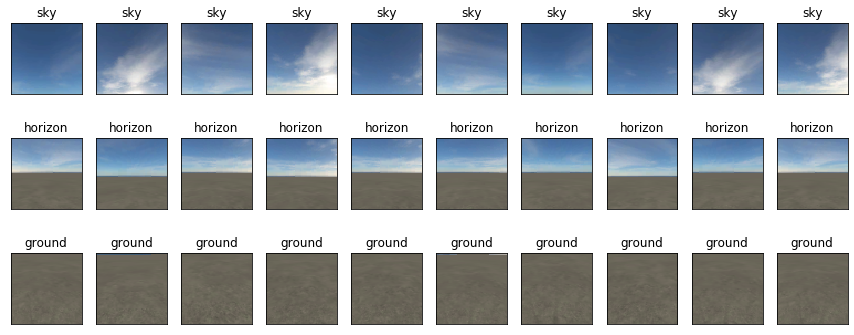

In [11]:
classes = ['sky','horizon','ground']

sky = np.where(X[:,1] < -30)[0]
horizon = np.where((X[:,1] >= -30) & (X[:,1] < 30))[0]
horizon_exact = np.where(abs(X[:,1]) < 3)[0]
ground = np.where(X[:,1] >= 30)[0]

fig, ax = plt.subplots(3, 10, figsize = (15, 6))
for j in range(10):
    ax[0][j].imshow(V[sky[rnd.randint(len(sky))],:])
    ax[1][j].imshow(V[horizon_exact[rnd.randint(len(horizon_exact))],:])
    ax[2][j].imshow(V[ground[rnd.randint(len(ground))],:])
    for i,label in enumerate(classes):
        ax[i][j].set_title(label)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])    
plt.show()

In [12]:
# check representation
len(sky), len(horizon), len(ground)

(369, 651, 260)

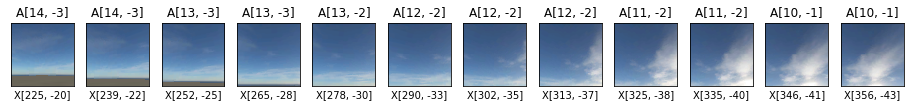

In [13]:
tail = [i for i in range(X.shape[0] - 13, X.shape[0] - 1)]
show_seq(A[tail,:], V[tail,:], X[tail,:])

## Online training
For the specific challenge we will need to define `make_batch` routine which constructs inputs and targets.

In [14]:
# common training rutine
def train_online(env, model, make_batch, epochs = 100, batch_size = 128,
                 shuffle = True, verbose = 0, visual = 0):
    # performance tracking
    log = {}
    # agent path (Trajectory.ipynb)
    path = init_trajectory(env)
    # running coordinates
    x = START.copy()
    # step counter
    index = 0
    # run: online epoch here means collecting 2 batches of data
    for e in range(epochs):
        # initialize 2 batches (train + test) to hold observations, actions and coords
        V = np.empty([batch_size * 2] + list(IMG_DIM))
        A = np.empty([batch_size * 2] + list(ACT_DIM))
        X = np.empty([batch_size * 2] + list(ACT_DIM))
        # collect a batch of data walking around
        for j in range(2 * batch_size):
            observation, action = make_move(env, path, index)
            V[j,:] = observation
            A[j,:] = action
            index += 1
            x += action
            X[j,:] = x
        if model and make_batch:
            # build inputs/targets
            data, labels = make_batch(V, A, X)
            # multiple inputs
            if isinstance(data, list):
                b = data[0].shape[0]//2
                inputs = [[d[:b,:] for d in data], [d[b:,:] for d in data]]
            else:
                b = data.shape[0]//2
                inputs = [data[:b,:], data[b:,:]]
            # multiple outputs
            if isinstance(labels, list):
                targets = [[d[:b,:] for d in labels], [d[b:,:] for d in labels]]
            else:
                targets = [labels[:b,:], labels[b:,:]]
            # train the model using first collected batch, test using second
            track = model.fit(inputs[0], targets[0], b, validation_data = (inputs[1], targets[1]),
                                  epochs = 2, shuffle = shuffle, verbose = verbose)
            # log performance
            for key in track.history:
                log[key] = log.get(key, []) + [np.mean(track.history[key])]
            # switch train and test data    
            track = model.fit(inputs[1], targets[1], b, validation_data = (inputs[0], targets[0]),
                                  epochs = 2, shuffle = shuffle, verbose = verbose)
            for key in track.history:
                log[key][-1] = (log[key][-1] + np.mean(track.history[key]))/2.
        # print progress
        if e == 0 or (e + 1)%(epochs//10) == 0:
            if visual:
                d = min(12, 2 * batch_size)
                show_seq(A[-d:,:], V[-d:,:], X[-d:,:])
            if 'loss' in log and 'val_loss' in log:
                print('{:>7} Loss  trainig: {:.4f} validation: {:.4f}'\
                        .format(e + 1, log['loss'][-1], log['val_loss'][-1]))
    # return log and last epoch data
    return log, V, A, X

In [ ]:
# check visual
log, V, A, X = train_online(env, 0, 0, visual = 1)

In [16]:
env.close()

We can save the data for *offline* training or if we want to use it withouth Unity3d installed. However, worth of notice, that might be gigabytes. We can train the agent streaming GIGs of data without saving anything to disk. Recording might be useful to debug environment: matching $Y$ and $X$ in our case to make sure the agent sees what we think it sees.

In [17]:
import pickle

#with open('observations.pkl', 'wb') as output:
#    pickle.dump(X, output, pickle.HIGHEST_PROTOCOL)
    
#with open('categories.pkl', 'wb') as output:
#    pickle.dump(Y, output, pickle.HIGHEST_PROTOCOL)